# TP 2: Bayesian Inversion for the Aquifer-River Exchange


In this lab, we will perform an inversion of the heat transfer model in a porous medium under transient conditions based on a reference simulation sampled at 4 points. The heat transfer occurs in a portion of a one-dimensional hyporheic zone of 5 meters in height, represented by 250 cells. The difference in head between the top and bottom of the column is set to ±5 cm.

The inversion will focus on the three uncertain parameters of this model, namely:

- Intrinsic permeability ($ k $)
- Thermal conductivity of the solid ( $\lambda_s $)
- Porosity ( $\omega$)
- Heat capacity ( $C$)

We will assume (prior distribution) that these variables are independent and follow the respective distributions:

- $ -\log_{10} k \sim \mathcal{U}(10, 15)$
- $ \lambda_s \sim \mathcal{U}(1, 5) $
- $ \omega \sim \mathcal{U}(0.01, 0.25) $
- $ C \sim \mathcal{U}(1500, 3500) $

The measurement points are located along the column at positions 10 cm, 20 cm, 30 cm, and 40 cm.




In [15]:
import sys
import os

# Ajoutez le chemin au sys.path
sys.path.append('/home/ariviere/Programmes/ginette/application/2024_TD_ENS/src_python')



# Listez les fichiers dans le répertoire pour vérifier que Init_folders.py est présent
print("\nFichiers dans le répertoire src_python :")
print(os.listdir('/home/ariviere/Programmes/ginette/application/2024_TD_ENS/src_python/'))

# Importez les modules
import numpy as np
from pathlib import Path
import pandas as pd
from scipy import interpolate
import matplotlib.pyplot as plt
import matplotlib as mpl
from IPython.display import display
import subprocess
import glob
import itertools
import seaborn as sns
import array

from Init_folders import prepare_ginette_directories, compile_ginette
import Direct_model
from Read_obs import process_obs_data
import Plot
import importlib
importlib.reload(Direct_model)
importlib.reload(Plot)
from Direct_model import setup_ginette, generate_zone_parameters, initial_conditions, boundary_conditions, run_direct_model, remove_first_two_days
from Plot import plot_obs, plot_obs_zoom, plot_compare_temperatures_obs_sim, plot_temperatures_profiles, plot_water_profiles_interpol,plot_temperature_profiles_interpol,plot_fluxes_timeseries,plot_domain,plot_temperatures_sim,plot_heat_flux_profiles_interpolated
prepare_ginette_directories('/home/ariviere/Programmes/ginette/application/2024_TD_ENS/SYNTHETIC_CASES/')


Fichiers dans le répertoire src_python :
['define_names.py', 'Plot.py', 'Read_obs.py', 'stat_critere.py', '__pycache__', 'Direct_model.py', 'Init_folders.py']
Current working directory: /home/ariviere/Programmes/ginette/application/2024_TD_ENS/SYNTHETIC_CASES
Directory 'SENSI' already exists.
Directory 'OUTPUT' already exists.


## 1. Reference Simulation and Sampling
### 1.1 Setting up a synthetic problem

First, let's define our modeling domain. We'll model temperature within the topmost five meters of a streambed at 251 equally-spaced grid points, for a grid spacing of 2 cm. Note that the first and last grid points are where we'll enforce Dirichlet boundary conditions on the temperature and hydraulic head, so we'll actually be computing temperatures at 249 locations. By modeling down to 5 m, we reach a depth where the temperature isn't affected significantly by daily surface temperature variations.

In [16]:
# size column meter
z_top = 0 # meters
z_bottom = -5 # meters
az=abs(z_top-z_bottom)
n_depths = 250


#discretisation : size cell in meter
dz=az/n_depths
print('dz=',dz)
dz_obs=0.1

dz= 0.02


Next, let's set up the times after initial time $t=0$ at which we'll compute temperatures. We will use a continuous-time, making the assumption of constant discharge and linearly varying boundary temperatures across each time step. Since the discharge and boundary temperatures change over time, the state space model is updated after each time step. So, the time step should be short enough that those assumptions are valid. For this problem setup, we'll use 10 minute time interval, and model 20 days worth of temperatures. The units of all time variables are seconds.

In [17]:
# 10 minute interval
dt = 600 # seconds
# 20 days
nb_day = 30# days
state=1
date_simul_bg=pd.to_datetime("2022/04/21 14:00:00")

z_obs=setup_ginette(dt, state, nb_day, z_top, z_bottom, az, dz, date_simul_bg,dz_obs)


la simulation commence à 2022-04-21 14:00:00


## 1.2 Physical constants

The physical constants used by `Ginette` are $\lambda$ in W/m&deg;C, and $C_s$ in $m^2$ $s^{-2}$ $C^{-1}$, as defined above.

### Intrinsic Permeability [m²]

$$
k = \frac{K \cdot \mu}{\rho \cdot g}
$$

Where:
- $ k $ = intrinsic permeability [m²]
- $ K $ = hydraulic conductivity [m/s]

#### Constant Parameters

- $ \mu $ = viscosity [Pa·s]
- $ \rho $ = density [kg/m³]
- $ g $ = gravitational acceleration [m/s²], approximately \( 9.81 \)

#### Calculation of Intrinsic Permeability
$$
k = 10^{\text{REF}_k}
$$

### Calculation of Thermal Capacity in Ginette Using the Following Relation:

$$
c_{pm} = c_w \cdot \rho_w \cdot n \cdot sat + c_s \cdot r \cdot (1 - \omega) + c_a \cdot \rho_a \cdot n \cdot (1 - sat)
$$

Where:

- $c_s$ is the specific heat capacity of the solid, with the value $\text{val}_c$ in m²/s²/°C. It is recommended to keep this value constant 1000 (kg/m³) because it is not possible to calibrate both parameters, $\rho$ and $c$, simultaneously.
- $J$ is in units of [kg m² s⁻²]
- $c_w = 4185 \, \text{m}^2/\text{s}^2/°C$
- $\rho_w$ represents density in kg/m³.
- $\rho_s$ is the density of solid grains, $[\text{kg/m}^3]$.



In [18]:
nb_zone=1
alt_thk=0
## Physical constants
# Porosité
REF_n = 0.05 # \omega

#-----------------------------------------------------------------
## Perméabilité intrinsèque [m2]  k=K*mu/(rho*g)
## K Conductivité hydraulique [m.s-1]
## Paramètres constants
### mu Viscosité [Pa.s]
### rho Densité [kg.m-3]
### g Gravité  9.81 [m2.s-1]

# k=10**REF_k
REF_k = -12 # m2
#### constant parameters
mu = 1e-6  # Dynamic viscosity in Pa.s 
rho = 1000  # Density in kg/m^3 
g = 9.81  # Acceleration due to gravity in m/s^2
REF_l = 1.8 # W/m deg C
# Calcul de la capacité thermique dans Ginette par la relation suivante :
#  c_pm = c_w * r_w * n * sat + c_s * r * (1-n) + c_a * r_a * n * (1-sat)
# rho_m imposé : 1000
# c_s Capacité thermique spécifique du solide
# val_c = c_s m2/s2/C. Il est conseillé de laisser cette valeur constante.
# Il n'est pas possible de calibrer les deux paramètres rho et c en même temps.
# J [kg m2 s−2]
# c_w = 4185D+00 m2/s2/C
# r_w = kg m-3itlectur
# Densité des grains solides rho_s = val_r [kg.m-3]
REF_r = 3500

## 1.3 Boundary and initial conditions

In [19]:
# Define the total simulation time in seconds (20 days)
t_final = nb_day * 24 * 60 * 60  # seconds
# Create a DataFrame to store boundary condition data
df_BC = pd.DataFrame()

# Create an array of time points from 0 to t_final with a step of dt
df_BC['times'] = np.arange(0, t_final, dt)
# Pre-calculate constants
seconds_per_day = 60 * 60 * 24
seconds_per_week = 7 * seconds_per_day
# Example of a DataFrame with times and days (assuming df_BC['times'] is already created)
df_BC['days'] = df_BC['times'] / seconds_per_day




#### Hydraulic heads


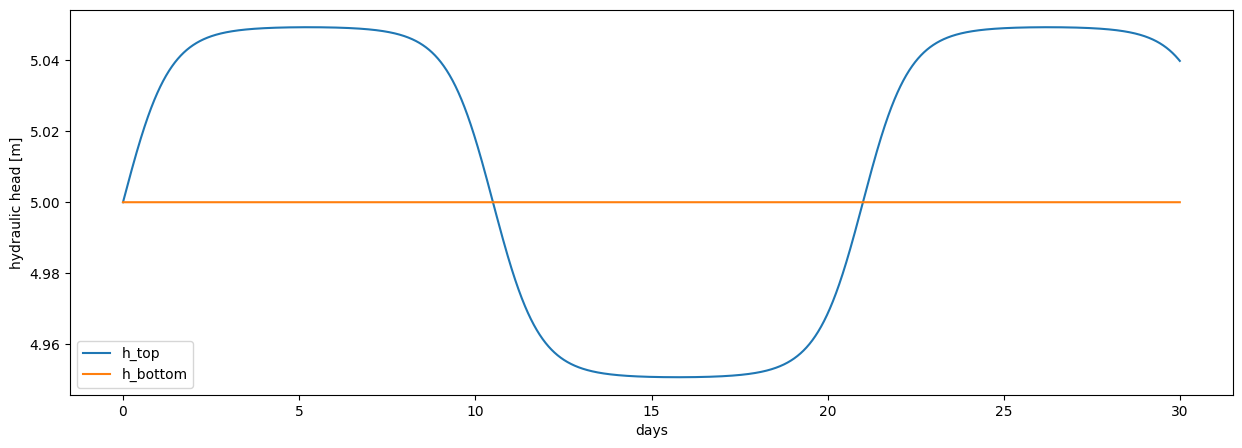

In [20]:
import numpy as np
import matplotlib.pyplot as plt

# Pre-calculate constants
two_pi = 2 * np.pi

# Linear temperature increase over time (0.3 degrees per day)
chg_per_day = 0.05

# Define a smooth square wave function using a sigmoid function
def smooth_square_wave(x, period):
    return 2 / (1 + np.exp(-5 * np.sin(two_pi * x / period))) - 1

# Reduce the frequency by increasing the period
reduced_period = 3 * seconds_per_week  # Double the period to reduce the frequency

# Calculate the top boundary using the smooth square wave function with reduced frequency
df_BC['h_top'] = ( 5 * smooth_square_wave(df_BC['times'], reduced_period) / 100  # Weekly fluctuation
                  + 5)  # Base temperature offset

# Set the bottom boundary to a constant value 
df_BC['h_bottom'] = 5 * np.ones_like(df_BC['times'])

# Plot the results
plt.figure(figsize=(15,5))
plt.plot(df_BC['days'], df_BC['h_top'], label='h_top')
plt.plot(df_BC['days'], df_BC['h_bottom'], label='h_bottom')
plt.xlabel('days')
plt.ylabel('hydraulic head [m]')
plt.legend()
plt.show()



#### Boundary temperatures
Boundary temperatures are needed to solve for temperatures inside the domain. Let's try using a diurnally varying top boundary temperature, and a constant bottom temperature. In addition, we'll give the top boundary a weekly variation, and a slight linear increase over the 20 day time frame.

In [21]:
# Pre-calculate constants
two_pi = 2 * np.pi

# Linear temperature increase over time (0.3 degrees per day)
deg_per_day = 0.3



# Calculate the top boundary temperature
df_BC['T_top'] = (5 * np.sin(two_pi * df_BC['times'] / seconds_per_day)  # Daily fluctuation
                  + deg_per_day * df_BC['days']  # Linear increase per day
                  + 3 * np.sin(two_pi * df_BC['times'] / seconds_per_week)  # Weekly fluctuation
                  + 17)  # Base temperature offset

# Set the bottom boundary temperature to a constant value (10 degrees)
df_BC['T_bottom'] = 10 * np.ones_like(df_BC['times'])

# Display the first few rows to check the results (optional)
print(df_BC.head())


   times      days     h_top  h_bottom      T_top  T_bottom
0      0  0.000000  5.000000         5  17.000000        10
1    600  0.006944  5.000260         5  17.238880        10
2   1200  0.013889  5.000519         5  17.477344        10
3   1800  0.020833  5.000779         5  17.714978        10
4   2400  0.027778  5.001039         5  17.951366        10


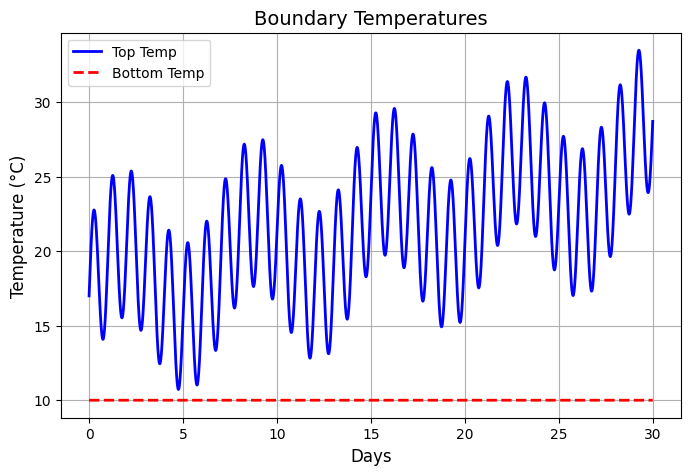

In [22]:
# Plot only the first 1000 points for quicker visualization
plt.figure(figsize=(8, 5))
plt.plot(df_BC['days'], df_BC['T_top'], label='Top Temp', color='b', lw=2)
plt.plot(df_BC['days'], df_BC['T_bottom'], label='Bottom Temp', color='r', ls='--', lw=2)

plt.xlabel('Days', fontsize=12)
plt.ylabel('Temperature (°C)', fontsize=12)
plt.title('Boundary Temperatures', fontsize=14)
plt.legend(fontsize=10)
plt.grid(True)

plt.show()

In [23]:
date_simul_bg=pd.to_datetime("2022/04/21 14:00:00")

# Create the obs_temp DataFrame
obs_temp = pd.DataFrame({
    'dates': date_simul_bg + pd.to_timedelta(df_BC['times'], unit='s'),
    'h_top': df_BC['h_top'],
    'h_bottom': df_BC['h_bottom'],
    'T_top': df_BC['T_top'],
    'T_bottom': df_BC['T_bottom']
})
# Display the obs_temp DataFrame
print(obs_temp)

                   dates     h_top  h_bottom      T_top  T_bottom
0    2022-04-21 14:00:00  5.000000         5  17.000000        10
1    2022-04-21 14:10:00  5.000260         5  17.238880        10
2    2022-04-21 14:20:00  5.000519         5  17.477344        10
3    2022-04-21 14:30:00  5.000779         5  17.714978        10
4    2022-04-21 14:40:00  5.001039         5  17.951366        10
...                  ...       ...       ...        ...       ...
4315 2022-05-21 13:10:00  5.040169         5  27.851551        10
4316 2022-05-21 13:20:00  5.040086         5  28.063943        10
4317 2022-05-21 13:30:00  5.040002         5  28.277874        10
4318 2022-05-21 13:40:00  5.039918         5  28.492933        10
4319 2022-05-21 13:50:00  5.039833         5  28.708708        10

[4320 rows x 5 columns]


### 1.3.1 Initial temperatures
An initial state is also required to solve for temperatures at later times. Let's make the simplifying assumption that temperatures vary linearly from top to bottom at time $t=0$.

In [24]:
z_obs=[-5]
initial_conditions(obs_temp, z_top, z_bottom, dz, z_obs)

### 1.3.2 Boundary conditions

In [25]:
boundary_conditions(obs_temp,dt)

'icl_gauche=-1\t\ticl=-1 flux impose sur une face, icl=-2 potentiel impose sur une face ; i2\tc Bord gauche\tC ECOULEMENT\nvalcl_gauche=00000000d+00\tvaleur flux (m/s) valeur charge (m)\t ; d9.0\t\t\t\tc Bord gauche\tC ECOULEMENT\nicl_droite=-1\t\t\t\t\t\t\t\t\t\t \tc Bord droit ; i2\tC ECOULEMENT\nvalcl_droite=00000000d+00\tvaleur flux (m/s) valeur charge (m)\t\t ; d9.0\t\t\tc Bord droit\tC ECOULEMENT\nicl_haut=-2\t\t\t\t\t\t\t\t\t\t\tc Surface ; i2\tC ECOULEMENT\nvalcl_haut=+0005.00d+00\tvaleur flux (m/s) valeur charge (m)\t\t ; d9.0\t\t\tc Surface  \tC ECOULEMENT\nicl_bas=-2\t\t\t\t\t\t\t\t\t\t\tc Base; i2\t\tC ECOULEMENT\nvalcl_bas=+0005.00d+00\tvaleur flux (m/s) valeur charge (m)\t\t\t ; d9.0\t\tc Base\t\tC ECOULEMENT\niclc_gauche=-1\t\t\t\t\t\t\t\t\t\t\tc Bord gauche ; i2\tC TRANSPORT\nvalclc_gauche=00000000d+00\t\t\t\t\t\t\t\t\t\tc Bord gauche  ; d9.0\tC TRANSPORT\niclc_droite=-1\t\t\t\t\t\t\t\t\t\t \tc Bord droit  ; i2\tC TRANSPORT\nvalclc_droite=00000000d+00\t\t\t\t\t\t\t\t\t\

## 1.4 run simulation

In [26]:
sim_temp=run_direct_model(date_simul_bg,z_bottom, dz, nb_zone, alt_thk, REF_k, REF_n, REF_l, REF_r, REF_k2=None, REF_n2=None, REF_l2=None, REF_r2=None) 

   600.00000000000000        0.0000000000000000        4.9899999999999993     
   1200.0000000000000       -7.0024706712138143E-009   4.9902597190920872     
   1800.0000000000000       -1.0710275124583860E-008   4.9905194230481458     
   2400.0000000000000       -1.3492762818495976E-008   4.9907790967357810     
   3000.0000000000000       -1.5810939570437768E-008   4.9910387250298660     
   3600.0000000000000       -1.7838344057017822E-008   4.9912982928161709     
   4200.0000000000000       -1.9661769787999221E-008   4.9915577849949839     
   4800.0000000000000       -2.1331827570393217E-008   4.9918171864847327     
   5400.0000000000000       -2.2881031214783436E-008   4.9920764822255856     
   6000.0000000000000       -2.4331714302898036E-008   4.9923356571830482     
   6600.0000000000000       -2.5699989152199123E-008   4.9925946963515502     
   7200.0000000000000       -2.6997925740724897E-008   4.9928535847580076     
   7800.0000000000000       -2.8234838237913210E-008

## 1.5 Plot the results

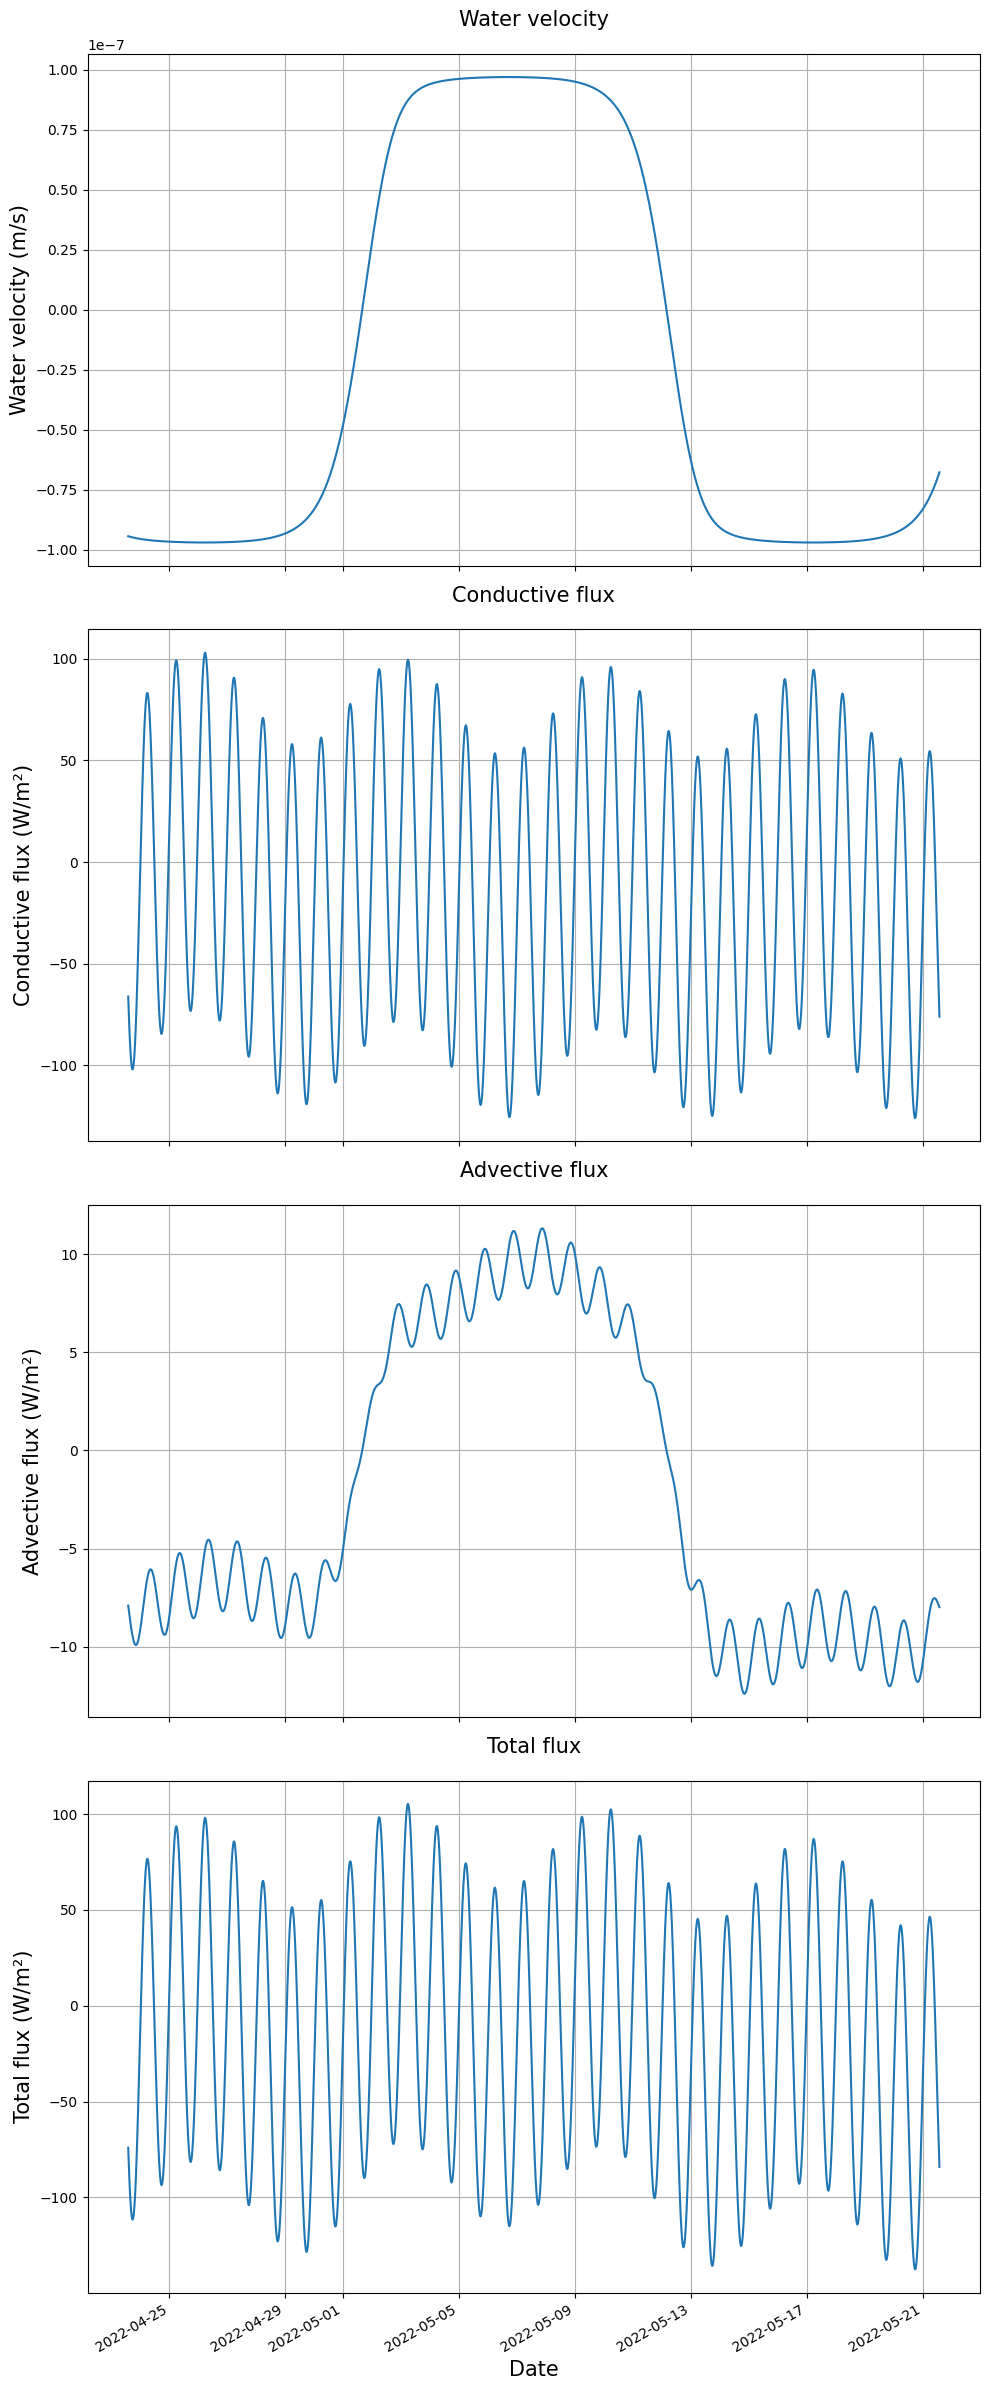

In [27]:
plot_fluxes_timeseries(date_simul_bg=pd.to_datetime("2022/04/21 14:00:00"))

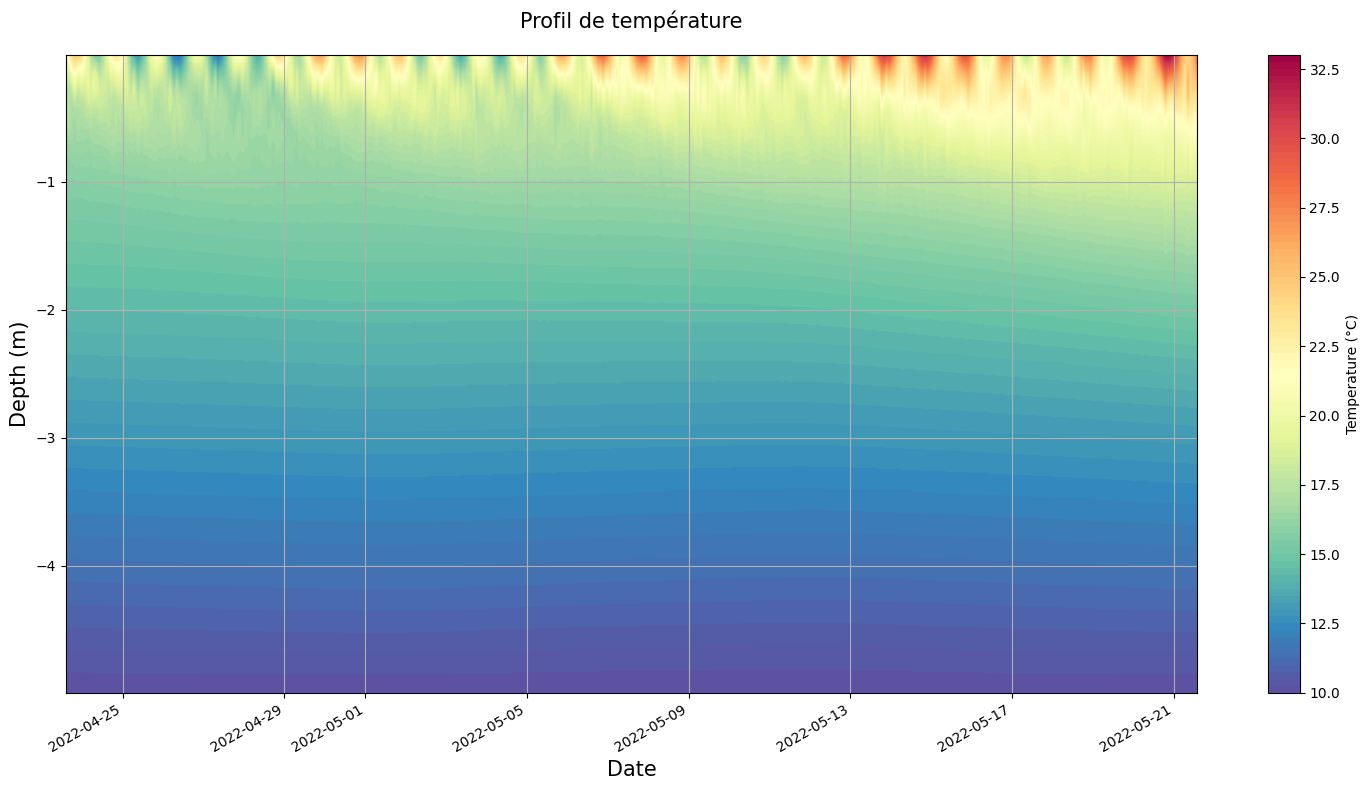

In [28]:
plot_temperature_profiles_interpol(date_simul_bg=pd.to_datetime("2022/04/21 14:00:00"))

In [29]:
sim_temp

,Time,Temp1,Temp2,Temp3,dates
0,600.0,16.867174,16.727273,16.587413,2022-04-21 14:10:00
1,1200.0,16.868900,16.727432,16.587526,2022-04-21 14:20:00
2,1800.0,16.874098,16.727664,16.587688,2022-04-21 14:30:00
3,2400.0,16.884420,16.727994,16.587876,2022-04-21 14:40:00
4,3000.0,16.900937,16.728494,16.588079,2022-04-21 14:50:00
...,...,...,...,...,...
4315,2589600.0,25.481746,24.847150,24.161858,2022-05-21 13:20:00
4316,2590200.0,25.542098,24.842912,24.152679,2022-05-21 13:30:00
4317,2590800.0,25.605908,24.840421,24.143842,2022-05-21 13:40:00
4318,2591400.0,25.673061,24.839692,24.135376,2022-05-21 13:50:00


## 1.6 Plot the simulated temperatures.
These temperature will be used as the observed data

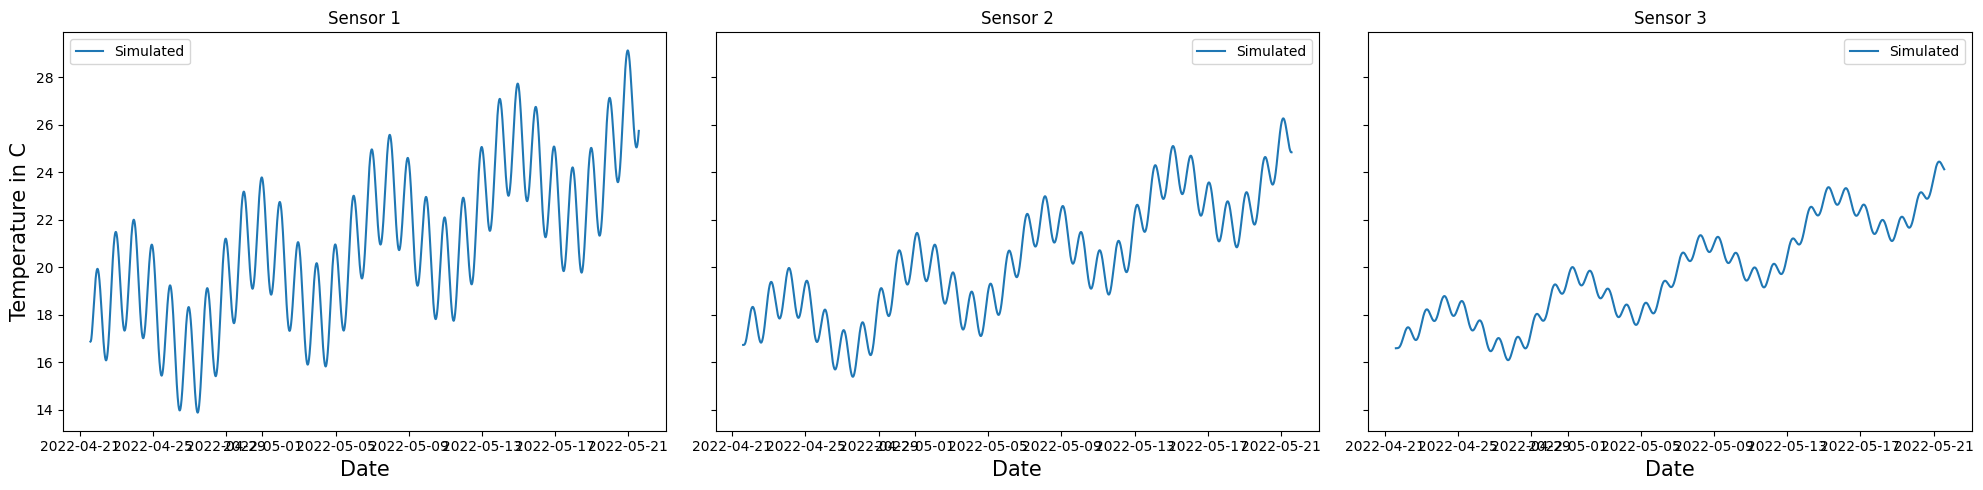

In [30]:
plot_temperatures_sim(sim_temp, fontsize=15)

# 2. Generate a table of parameters 

# 3. Simulate the temperatures 

# 4. Compare with static metrics the simulated and observed temperature

# 5. Find a representation to test the sensibility of the parameters